# 1.主题模型简介

LDA 主题模型 (Latent Dirichlet Allocation) 是Blei等人于2003年提出的一种动态文档主题识别模型。其基本思想是：（1）每个文档都是若干主题按一定比例随机混合而成的。例如，在双主题模型中，可以认为文档1是10%的主题A和90%的主题B的混合，而文档2是70% 的主题A和30%的主题B的混合，以此类推。概率越高代表此主题与文档的相关性越高。（2）其中，每个主题又是若干个词汇按一定比例随机混合而成的，主题的特征可以用单词的分布来表示。例如， “国际合作”主题可能包含的词语有政府、沟通、互助等。
LDA主题模型分析过程中包含三个核心要素: 词汇、主题与文档。其任务就是以无监督计算的方式挖掘文档中不同单词的分布规律，将每个文档表示成一个词汇分布向量，然后通过对文本集合的分析，推断出每个主题的词汇分布和每篇文档的主题分布。

# 2.【课程】构建LDA主题模型

In [1]:
import pandas as pd     # 数据表
import numpy as np     # 数组
import re     # 正则表达式
import jieba     # 中文分词
import matplotlib.pyplot as plt     # 画图
from gensim import corpora, models
import pyLDAvis     # 交互式LDA可视化
import pyLDAvis.gensim_models as gensimvis

In [2]:
df = pd.read_excel('text_analysis_weibo_sample.xlsx', index_col = 0)

In [3]:
df.head()

,index,标题/微博内容,点赞,转发,评论,账号昵称UID加密,粉丝数,关注数,地域
0,34121,国债：地产行业重磅利好提振风险偏好，期债低开低走 国债期货全线收跌，10年期主力...,0,0,0,e5df796860e68f403bcf9651bab4d42e,0,0,其他
1,40230,#喜迎二十大 忠诚保平安#,0,0,0,6e35cb69ad52f20de5e28197b2e85306,405444,252,广西
2,7714,注意！事关明日教资考试！福建省教育考试院发布补充公告 福建省2022年下半年全国中小学教师...,0,0,0,e6953217442e6c06a7af23eee5e185f2,53264,2177,福建
3,27378,近日，“千年大计”雄安新区迎来五周岁生日。从“一张白纸...,0,0,0,NaN,0,0,北京
4,15435,樊振东牛逼！,0,0,0,344af41eac516375c04dee6325e763cc,8,51,山东


### 2.1 语料预处理 

#### 剔除符号与数字

In [4]:
def remove_nums(text):
    nonums = re.sub('[^\u4e00-\u9fa5]+', '', text)
    return nonums
test = df['标题/微博内容'][0]
remove_nums(test)[:100]

'国债地产行业重磅利好提振风险偏好期债低开低走国债期货全线收跌年期主力合约跌年期主力合约跌年期主力合约跌三大主力合约均创逾一年收盘新低行情解读公开市场方面央行开展了亿元天期逆回购操作中标利率亿元逆回购到'

#### 分词

In [5]:
# 加载中文停用词词典，可个性化设置
# stopwords = open('stopwords.txt', encoding = 'utf-8').read()

def clean_text(text):
    words = jieba.lcut(text)
    # words = [w for w in words if w not in stopwords and w!='[' and w!=']']
    return ' '.join(words)

test = df['标题/微博内容'][0]
clean_text(test)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/87/6c4tjldn0b9bqgff58m4gx540000gn/T/jieba.cache
Loading model cost 0.354 seconds.
Prefix dict has been built successfully.


'    国债 ： 地产 行业 重磅 利好 提振 风险 偏好 ， 期债 低开 低 走           国债 期货 全线 收跌 ， 10 年期 主力 合约 跌 0.37% ， 5 年期 主力 合约 跌 0.24% ， 2 年期 主力 合约 跌 0.11% ， 三大 主力 合约 均 创 逾 一年 收盘 新低 。         行情 解读 ：         1 ， 公开市场 方面 ， 央行 开展 了 800 亿元 7 天期 逆 回购 操作 ， 中标 利率 2.0% ， 20 亿元 逆 回购 到期 ， 因此 当日 净 投放 780 亿元 。         2 ， 资金面 方面 ， 央行 公开市场 逆 回购 继续 加力 ， 不过 银行 间 市场 周二 资金 供给 趋于 收敛 ， 七天 回购 加权 利率 进一步 上行 。 长期 资金 方面 ， 全国 和 主要 股份制 银行 一年期 同业 存单 报价 仍 维持 在 2.45% 水平 ， 不过 目前 尚无 成交量 配合 。         3 ， 房地产 行业 再度 迎来 重磅 利好 。 证监会 宣布 在 涉房 企业 股权 融资 方面 调整 优化 五项 措施 ， 并 自即日起 施行 。 随着 证监会 支持 房企 股权 融资 这 “ 第三支 箭 ” 正式 发射 ， 信贷 、 债券 、 股权 三个 融资 渠道 “ 三箭 齐发 ” ， 合力 推动 房地产 融资 。 — — “ 第三支 箭 ” 快速 落地 ， 或 将 为 房地产 行业 注入 较 大规模 的 增量 资金 和 资产 ， 促进 行业 平稳 健康 发展 。 在 短短 20 天 的 时间 内 政策 端 “ 三箭 齐发 ” 强势 托底 ， 提振 各方 的 信心 。 看好 全 行业 的 信用 复苏 以及 在 因城 施策 空间 逐步 打开 下 的 销售 回暖 。         4 ， 国务院 联防 联控 机制 11 月 29 日 15 : 00 召开 新闻 发布会 。 针对 “ 考虑 到 最近 个别 地方 的 不满情绪 ， 政府 是否 会 重新考虑 疫情 应对 政策 ” 的 问题 ， 国家 卫生 健康 委 新闻 发言人 、 宣传司 副司长 米锋 称 ， 疫情 发生 以来 ， 中国政府 一直 根据 病毒 变异 的 特点 和 临床 治疗 的 实践 认识 ， 边 防控 、 边 研究 

In [6]:
df['标题/微博内容'] = df['标题/微博内容'].astype(str)
df['微博内容分词'] = df['标题/微博内容'].apply(remove_nums)
df['微博内容分词'] = df['微博内容分词'].apply(clean_text)
df['微博内容分词'] = df['微博内容分词'].apply(lambda x: x.split())
df

,index,标题/微博内容,点赞,转发,评论,账号昵称UID加密,粉丝数,关注数,地域,微博内容分词
0,34121,国债：地产行业重磅利好提振风险偏好，期债低开低走 国债期货全线收跌，10年期主力...,0,0,0,e5df796860e68f403bcf9651bab4d42e,0,0,其他,"[国债, 地产, 行业, 重磅, 利好, 提振, 风险, 偏好, 期债, 低开, 低, 走,..."
1,40230,#喜迎二十大 忠诚保平安#,0,0,0,6e35cb69ad52f20de5e28197b2e85306,405444,252,广西,"[喜迎, 二十大, 忠诚, 保平安]"
2,7714,注意！事关明日教资考试！福建省教育考试院发布补充公告 福建省2022年下半年全国中小学教师...,0,0,0,e6953217442e6c06a7af23eee5e185f2,53264,2177,福建,"[注意, 事关, 明日, 教资, 考试, 福建省, 教育, 考试院, 发布, 补充, 公告,..."
3,27378,近日，“千年大计”雄安新区迎来五周岁生日。从“一张白纸...,0,0,0,NaN,0,0,北京,"[近日, 千年, 大计, 雄安, 新区, 迎来, 五周岁, 生日, 从, 一张白纸, 到, ..."
4,15435,樊振东牛逼！,0,0,0,344af41eac516375c04dee6325e763cc,8,51,山东,"[樊振东, 牛, 逼]"
...,...,...,...,...,...,...,...,...,...,...
95,14034,老公好漂亮[舔屏],0,0,0,aa7af97ae98cbe8983e559b948ecfabf,825,191,北京,"[老公, 好, 漂亮, 舔, 屏]"
96,35249,恭喜@张小娜呀娜 1名用户获得【小飞T】。C官方唯一抽奖工具@C抽奖平台 对本次抽奖进行监督...,0,0,2,f538513e5801c275cbcf285517a8ee62,51709,20,北京,"[恭喜, 张小娜, 呀, 娜, 名, 用户, 获得, 小飞, 官方, 唯一, 抽奖, 工具,..."
97,39598,接不动了，居民部门负债率提升空间太有限了。现在动辄几万一平米，总价高，月供高，预期转差，还怎...,0,0,0,2e76c39b6665a0b6f5bdc4c35f36f573,0,59,四川,"[接不动, 了, 居民, 部门, 负债率, 提升, 空间, 太, 有限, 了, 现在, 动辄..."
98,48977,目前电子烟政策已从制定阶段逐渐走向实施阶段，而主要的电子烟公司股价下跌幅度高达70%-...,0,0,0,NaN,0,0,北京,"[目前, 电子, 烟, 政策, 已, 从, 制定, 阶段, 逐渐, 走向, 实施, 阶段, ..."


### 2.2 训练LDA

In [7]:
dictionary = corpora.Dictionary(df['微博内容分词'])     # 根据分词结果创建字典
corpus = [dictionary.doc2bow(text) for text in df['微博内容分词']]     # 根据分词结果创建语料库

In [8]:
# 训练LDA模型
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

In [9]:
# 查看主题
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.035*"的" + 0.012*"郑州" + 0.009*"在" + 0.006*"是" + 0.006*"亿元"')
(1, '0.040*"的" + 0.009*"了" + 0.009*"在" + 0.006*"月" + 0.005*"加息"')
(2, '0.006*"的" + 0.004*"自闭症" + 0.004*"你" + 0.003*"转发" + 0.003*"世界"')
(3, '0.016*"的" + 0.015*"月" + 0.013*"万吨" + 0.009*"市场" + 0.008*"日"')
(4, '0.031*"的" + 0.011*"电子" + 0.010*"烟" + 0.008*"年" + 0.008*"在"')


In [10]:
df['微博内容分词'].iloc[0]

['国债',
 '地产',
 '行业',
 '重磅',
 '利好',
 '提振',
 '风险',
 '偏好',
 '期债',
 '低开',
 '低',
 '走',
 '国债',
 '期货',
 '全线',
 '收跌',
 '年期',
 '主力',
 '合约',
 '跌',
 '年期',
 '主力',
 '合约',
 '跌',
 '年期',
 '主力',
 '合约',
 '跌三大',
 '主力',
 '合约',
 '均',
 '创',
 '逾',
 '一年',
 '收盘',
 '新低',
 '行情',
 '解读',
 '公开市场',
 '方面',
 '央行',
 '开展',
 '了',
 '亿元',
 '天期',
 '逆',
 '回购',
 '操作',
 '中标',
 '利率',
 '亿元',
 '逆',
 '回购',
 '到期',
 '因此',
 '当日',
 '净',
 '投放',
 '亿元',
 '资金面',
 '方面',
 '央行',
 '公开市场',
 '逆',
 '回购',
 '继续',
 '加力',
 '不过',
 '银行',
 '间',
 '市场',
 '周二',
 '资金',
 '供给',
 '趋于',
 '收敛',
 '七天',
 '回购',
 '加权',
 '利率',
 '进一步',
 '上行',
 '长期',
 '资金',
 '方面',
 '全国',
 '和',
 '主要',
 '股份制',
 '银行',
 '一年期',
 '同业',
 '存单',
 '报价',
 '仍',
 '维持',
 '在',
 '水平',
 '不过',
 '目前',
 '尚无',
 '成交量',
 '配合',
 '房地产',
 '行业',
 '再度',
 '迎来',
 '重磅',
 '利好',
 '证监会',
 '宣布',
 '在',
 '涉房',
 '企业',
 '股权',
 '融资',
 '方面',
 '调整',
 '优化',
 '五项',
 '措施',
 '并',
 '自即日起',
 '施行',
 '随着',
 '证监会',
 '支持',
 '房企',
 '股权',
 '融资',
 '这',
 '第三支',
 '箭',
 '正式',
 '发射',
 '信贷',
 '债券',
 '股权',
 '三个',
 '融资',
 '渠道',
 '三箭',
 '齐发',
 '合

In [11]:
for index, score in sorted(lda_model[corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.8998741507530212	 
Topic: 0.031*"的" + 0.011*"电子" + 0.010*"烟" + 0.008*"年" + 0.008*"在" + 0.008*"中国" + 0.006*"和" + 0.006*"考生" + 0.005*"经济" + 0.005*"亿元"

Score: 0.09969573467969894	 
Topic: 0.016*"的" + 0.015*"月" + 0.013*"万吨" + 0.009*"市场" + 0.008*"日" + 0.008*"库存" + 0.007*"较" + 0.006*"需求" + 0.006*"预期" + 0.006*"为"


In [12]:
documents = df['微博内容分词'].values

In [13]:
# Function to infer topics for a document
def infer_topics(lda_model, document):
    bow = dictionary.doc2bow(document)
    topics = lda_model.get_document_topics(bow)
    return topics

# Print topics for each document
for i, doc in enumerate(documents[:10]):
    doc_topics = infer_topics(lda_model, doc)
    print(f"Document {i+1}:")
    print(doc_topics)
    print()

Document 1:
[(3, 0.099701285), (4, 0.89986885)]

Document 2:
[(0, 0.04010599), (1, 0.040097557), (2, 0.040147826), (3, 0.8395562), (4, 0.040092368)]

Document 3:
[(4, 0.9974011)]

Document 4:
[(1, 0.9993343)]

Document 5:
[(0, 0.05013367), (1, 0.051437523), (2, 0.05018755), (3, 0.79724497), (4, 0.050996292)]

Document 6:
[(0, 0.91028285), (1, 0.022531249), (2, 0.02224193), (3, 0.022577953), (4, 0.02236597)]

Document 7:
[(0, 0.0126707805), (1, 0.94953996), (2, 0.012602374), (3, 0.012612658), (4, 0.012574231)]

Document 8:
[(0, 0.10021951), (1, 0.10096122), (2, 0.10059037), (3, 0.5976762), (4, 0.10055267)]

Document 9:
[(2, 0.9719504)]

Document 10:
[(0, 0.99933696)]



### 2.3 可视化

In [14]:
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary, n_jobs=1) # 备注：上述语句如果在数据量比较大的时候跑不出来，可以选择加一个n_jobs=1的参数，降低计算量，避免报错
# 显示可视化界面
pyLDAvis.display(lda_vis)

In [15]:
# 导出可视化结果到html
# pyLDAvis.save_html(lda_vis, 'lda_visualization.html')

# 3.【实战】基于微博生育数据构建LDA模型

### 3.1 数据预处理

In [30]:
import pandas as pd     # 数据表
import numpy as np     # 数组
import re     # 正则表达式
import jieba     # 中文分词
import matplotlib.pyplot as plt     # 画图
from gensim import corpora, models
import pyLDAvis     # 交互式LDA可视化
import pyLDAvis.gensim_models as gensimvis

In [64]:
df = pd.read_excel('sy.xlsx', index_col = 0)

In [65]:
df.head()

,sig,date,comment
nick,,,
Adam和她的狗,未认证,2022年1月,#官方通报徐州丰县生育八孩女子情况#大过年的想起来就生气该死的董狗男马上给我死啊别活到202...
狗不理小馄饨,微博个人认证,2022年1月,//@喝咖啡的猫大人:一语道破//@李天飞大话西游:哈哈哈哈哈//@陨石盆栽:且到现在这破春...
BABA嵐川,未认证,2022年1月,听春晚的感想只有：生育率这么低都是你们的福报?
王皮哔哔叭叭,未认证,2022年1月,#官方通报徐州丰县生育八孩女子情况#徐州政府，很想过新年吧你敢过吗?
干国王,未认证,2022年1月,//@张捷观察-谁是谁非任评说:再把此文顶起来，在B站等地，都被和谐了。此文对理解计划生育后...


In [66]:
def remove_nums(text):
    nonums = re.sub('[^\u4e00-\u9fa5]+', '', text)
    return nonums
test = df['comment'][0]
remove_nums(test)[:100]

/var/folders/87/6c4tjldn0b9bqgff58m4gx540000gn/T/ipykernel_12864/3882169887.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test = df['comment'][0]


'官方通报徐州丰县生育八孩女子情况大过年的想起来就生气该死的董狗男马上给我死啊别活到年希望这个畜生能被除夕夜的鞭炮炸死希望姐姐能赶紧找到家人回家过年'

#### 分词

In [68]:
# 加载中文停用词词典，可个性化设置
stopwords = open('stopwords.txt', encoding = 'utf-8').read()

def clean_text(text):
    words = jieba.lcut(text)
    words = [w for w in words if w not in stopwords and w!='[' and w!=']']
    return ' '.join(words)

test = df['comment'][0]
clean_text(test)

/var/folders/87/6c4tjldn0b9bqgff58m4gx540000gn/T/ipykernel_12864/2954219263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test = df['comment'][0]


'官方 通报 徐州 丰县 生育 八孩 女子 情况 大过年 想 生气 该死 董狗 马上 死 别活 2022 希望 畜生 除夕夜 鞭炮 炸死 希望 姐姐 赶紧 找到 家人 回家 过年'

In [69]:
df['标题/微博内容'] = df['comment'].astype(str)
df['微博内容分词'] = df['标题/微博内容'].apply(remove_nums)
df['微博内容分词'] = df['微博内容分词'].apply(clean_text)
df['微博内容分词'] = df['微博内容分词'].apply(lambda x: x.split())
df

,sig,date,comment,标题/微博内容,微博内容分词
nick,,,,,
Adam和她的狗,未认证,2022年1月,#官方通报徐州丰县生育八孩女子情况#大过年的想起来就生气该死的董狗男马上给我死啊别活到202...,#官方通报徐州丰县生育八孩女子情况#大过年的想起来就生气该死的董狗男马上给我死啊别活到202...,"[官方, 通报, 徐州, 丰县, 生育, 八孩, 女子, 情况, 大过年, 想, 生气, 该..."
狗不理小馄饨,微博个人认证,2022年1月,//@喝咖啡的猫大人:一语道破//@李天飞大话西游:哈哈哈哈哈//@陨石盆栽:且到现在这破春...,//@喝咖啡的猫大人:一语道破//@李天飞大话西游:哈哈哈哈哈//@陨石盆栽:且到现在这破春...,"[喝咖啡, 猫, 大人, 一语道破, 李天飞, 大话西游, 哈哈哈, 陨石, 盆栽, 这破,..."
BABA嵐川,未认证,2022年1月,听春晚的感想只有：生育率这么低都是你们的福报?,听春晚的感想只有：生育率这么低都是你们的福报?,"[听, 春晚, 感想, 生育率, 低, 福报]"
王皮哔哔叭叭,未认证,2022年1月,#官方通报徐州丰县生育八孩女子情况#徐州政府，很想过新年吧你敢过吗?,#官方通报徐州丰县生育八孩女子情况#徐州政府，很想过新年吧你敢过吗?,"[官方, 通报, 徐州, 丰县, 生育, 八孩, 女子, 情况, 徐州, 政府, 想, 新年]"
干国王,未认证,2022年1月,//@张捷观察-谁是谁非任评说:再把此文顶起来，在B站等地，都被和谐了。此文对理解计划生育后...,//@张捷观察-谁是谁非任评说:再把此文顶起来，在B站等地，都被和谐了。此文对理解计划生育后...,"[张捷, 观察, 谁是谁非, 评说, 此文, 站, 和谐, 此文, 理解, 计划生育, 人口..."
...,...,...,...,...,...
icedAmericano_不加糖,未认证,2023年12月,一、人参果对环境条件的要求当气温稳定在10℃时开始萌发新芽，18℃以上开花结果。生育适温为1...,一、人参果对环境条件的要求当气温稳定在10℃时开始萌发新芽，18℃以上开花结果。生育适温为1...,"[人参果, 环境, 条件, 气温, 稳定, 萌发, 新芽, 开花结果, 生育, 适温, 气温..."
妇幼卫士,微博个人认证,2023年12月,卫士讲生育异性之间的关系一直是一个备受关注的话题。有人喜欢互相调侃，有人则喜欢默默关注对方...,卫士讲生育异性之间的关系一直是一个备受关注的话题。有人喜欢互相调侃，有人则喜欢默默关注对方...,"[卫士, 讲, 生育, 异性, 关系, 备受, 话题, 有人, 喜欢, 调侃, 有人, 喜欢..."
第N个有故事的人,未认证,2023年12月,回复@扎导一般斯林:也只有墙内新南向才没搞成功。台湾现在每年准备吸纳十万印度劳工，连低生育率...,回复@扎导一般斯林:也只有墙内新南向才没搞成功。台湾现在每年准备吸纳十万印度劳工，连低生育率...,"[回复, 扎导, 斯林, 墙内, 南向, 搞, 成功, 台湾, 吸纳, 十万, 印度, 劳工..."


### 3.2 LDA

In [70]:
dictionary = corpora.Dictionary(df['微博内容分词'])     # 根据分词结果创建字典
corpus = [dictionary.doc2bow(text) for text in df['微博内容分词']]     # 根据分词结果创建语料库

/var/folders/87/6c4tjldn0b9bqgff58m4gx540000gn/T/ipykernel_12864/83336660.py:14: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  mdl.train(20)


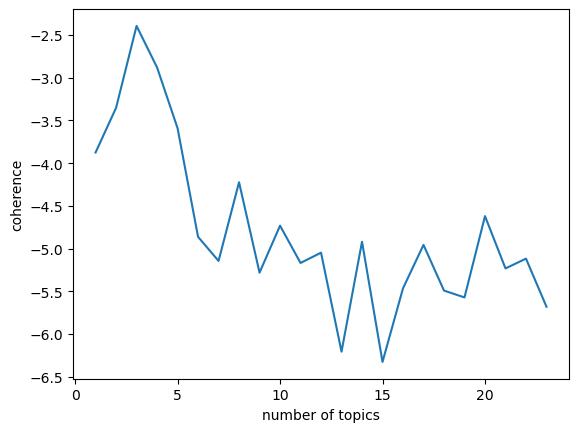

In [71]:
#确定k值
#利用一致性确定k值
import tomotopy as tp
def find_k(docs, min_k=1, max_k=24, min_df=2):
    #min_df 词语最少出现在2个文档中
    import matplotlib.pyplot as plt
    scores = []
    for k in range(min_k, max_k):
        #seed随机种子
        mdl = tp.LDAModel(min_df=min_df, k=k, seed=555)
        for words in docs:
            if words:
                mdl.add_doc(words)
        mdl.train(20)
        coh = tp.coherence.Coherence(mdl)
        scores.append(coh.get_score())

    #x = list(range(min_k, max_k - 1))  # 区间最右侧的值,不能大于max_k
    #print(x)
    #print()
    plt.plot(range(min_k, max_k), scores)
    plt.xlabel("number of topics")
    plt.ylabel("coherence")
    plt.show()
    
    
find_k(docs=df['微博内容分词'], min_k=1, max_k=24, min_df=2)

### 上图表明 k值在2-3之间将会达到更好的效果

In [72]:
# 训练LDA模型
lda_model = models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

In [73]:
# 查看主题
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.026*"生育" + 0.013*"展开" + 0.013*"孩子" + 0.010*"结婚" + 0.008*"生育率"')
(1, '0.013*"展开" + 0.013*"生育" + 0.005*"月" + 0.004*"生育率" + 0.004*"岁"')
(2, '0.026*"生育" + 0.015*"女性" + 0.012*"女子" + 0.010*"丰县" + 0.009*"八孩"')


LDA呈现出3个主题，第一个主题是婚姻，表明讨论生育时用户多从婚姻角度开启交流；第二个主题是时间；第三个主题是丰县八孩时间，表明网友围绕生育领域内较为严重的社会事件进行了讨论。

In [75]:
df['微博内容分词'].iloc[0]

['官方',
 '通报',
 '徐州',
 '丰县',
 '生育',
 '八孩',
 '女子',
 '情况',
 '大过年',
 '想',
 '生气',
 '该死',
 '董狗',
 '马上',
 '死',
 '别活',
 '希望',
 '畜生',
 '除夕夜',
 '鞭炮',
 '炸死',
 '希望',
 '姐姐',
 '赶紧',
 '找到',
 '家人',
 '回家',
 '过年']

In [76]:
for index, score in sorted(lda_model[corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.6712437272071838	 
Topic: 0.026*"生育" + 0.015*"女性" + 0.012*"女子" + 0.010*"丰县" + 0.009*"八孩" + 0.008*"展开" + 0.006*"全文" + 0.006*"主角" + 0.006*"小说" + 0.006*"徐州"

Score: 0.3170103430747986	 
Topic: 0.026*"生育" + 0.013*"展开" + 0.013*"孩子" + 0.010*"结婚" + 0.008*"生育率" + 0.005*"想" + 0.005*"女性" + 0.004*"真的" + 0.004*"建议" + 0.004*"取消"

Score: 0.011745953932404518	 
Topic: 0.013*"展开" + 0.013*"生育" + 0.005*"月" + 0.004*"生育率" + 0.004*"岁" + 0.003*"中国" + 0.003*"提高" + 0.003*"女性" + 0.003*"患者" + 0.003*"母亲"


In [77]:
documents = df['微博内容分词'].values

In [78]:
# Function to infer topics for a document
def infer_topics(lda_model, document):
    bow = dictionary.doc2bow(document)
    topics = lda_model.get_document_topics(bow)
    return topics

# Print topics for each document
for i, doc in enumerate(documents[:10]):
    doc_topics = infer_topics(lda_model, doc)
    print(f"Document {i+1}:")
    print(doc_topics)
    print()

Document 1:
[(0, 0.31700578), (1, 0.011745957), (2, 0.67124826)]

Document 2:
[(0, 0.010865904), (1, 0.010461173), (2, 0.9786729)]

Document 3:
[(0, 0.8971675), (1, 0.04843057), (2, 0.05440187)]

Document 4:
[(0, 0.032898176), (1, 0.025819954), (2, 0.9412819)]

Document 5:
[(0, 0.43196195), (1, 0.051871233), (2, 0.5161668)]

Document 6:
[(0, 0.12134889), (1, 0.029317765), (2, 0.84933335)]

Document 7:
[(0, 0.026393175), (1, 0.019766603), (2, 0.95384026)]

Document 8:
[(0, 0.012061818), (1, 0.011942477), (2, 0.9759957)]

Document 9:
[(2, 0.98159295)]

Document 10:
[(0, 0.3601299), (2, 0.6305295)]



### 3.3 可视化

In [79]:
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary, n_jobs=1) # 备注：上述语句如果在数据量比较大的时候跑不出来，可以选择加一个n_jobs=1的参数，降低计算量，避免报错
# 显示可视化界面
pyLDAvis.display(lda_vis)